# Simulate thermal noise on a HO (the membrane)
We start from $\ddot{x}+\frac{\omega_{0}}{Q} \dot{x}+\omega_{0}^{2} x=\frac{F(t)}{m_{e f f}}$. We estimate $k=m\omega_{0}^2 \approx 1 N/m$ Also $\omega_0 = 1$ MHz

In [1]:
import numpy as np
k_veer = 18
omega0 = 1e6*2*np.pi
m_eff = k_veer/(omega0**2)
print(m_eff)
Q = 100

4.5594532639052e-13


The thermal noise term consists of many random interaction -> is a gaussian (central limit theorem). From equipartition we know $\frac{m_{eff}\omega_0^2}{2}\langle x(t)^2\rangle = \frac{k_B T}{2}$. The expactation of x^2 also follows from parseval:
$\left\langle x^{2}(t)\right\rangle=\frac{1}{2 \pi} \int_{-\infty}^{\infty} S_{xx}(\omega) d \omega$. Where $S_{xx}$ is the power spectrum of x(t). From the starting equations of motions we obtain the following:
$\chi(\omega)=\frac{\mathscr{F}\left[x(t)\right]}{\mathscr{F}[F(t)]}=\frac{1}{m_{e f f}\left(\omega_{0}^{2}-\omega^{2}+\frac{i \omega_{0} \omega}{Q}\right)}$. <br>Now 
$S_{xx}(\omega) = |\chi(\omega)|^2S_{FF}(\omega)$. But the fourier transform of a gaussian white noise is simply a constant! <br>
$\left\langle x^{2}(t)\right\rangle=\frac{S_{F F}^{t h}}{2 \pi m_{e f f}} \int_{-\infty}^{\infty} \frac{1}{\left(\omega_{0}^{2}-\omega^{2}+\frac{i \omega_{0} \omega}{Q}\right)} d \omega$ From which the amplitude of thermal noise in the frequency spectrum can be determined <br>
$S_{F F}^{t h}=\frac{4 k_{B} T \omega_{0} m_{e f f}}{Q}$

In [2]:
from scipy.constants import k
T = 293
Sth = 4*293*k*omega0*m_eff/Q
fs = 8e6
Nt = 2**14
t = np.arange(Nt)/fs
f = np.fft.fftfreq(Nt,1/fs)
F_std = np.sqrt(Sth*fs)
F = np.random.normal(0,F_std,Nt)
h = (1/m_eff)*1/((omega0)**2 - ((2*np.pi)*f)**2 +1j*((2*np.pi)*f*omega0)/Q)



In [15]:
f_ampl = np.sqrt((Nt*fs)*Sth)
phases = np.random.uniform(-np.pi,np.pi,Nt)
noise_ff = np.fft.fft(F)#f_ampl*np.exp(1j*phases)

x = np.real(np.fft.ifft(noise_ff*h))

In [3]:

import matplotlib.pyplot as plt
plt.plot(t,x)
print(np.std(x))
print(.5*k*293)
print(.5*m_eff*omega0**2*np.std(x)**2)

NameError: name 'x' is not defined

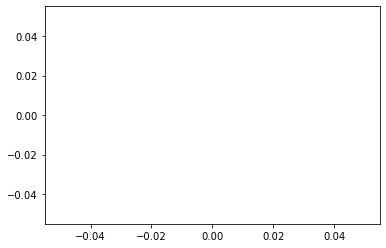

In [17]:
plt.plot(t[200000:250000],x[200000:250000])

(950000.0, 1050000.0)

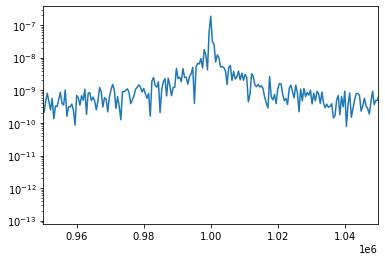

In [18]:



plt.semilogy(f[:len(f)//2],(np.abs(np.fft.fft(x)))[:len(f)//2])
plt.xlim(9.5e5,10.5e5)

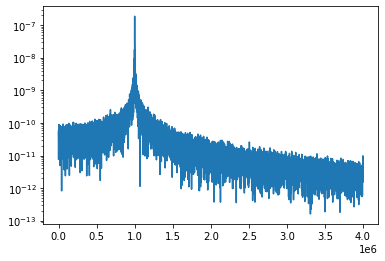

In [19]:
plt.semilogy(f[:len(f)//2],np.abs(np.fft.fft(x)[:len(f)//2]))


Run it a bunch of times

(950000.0, 1050000.0)

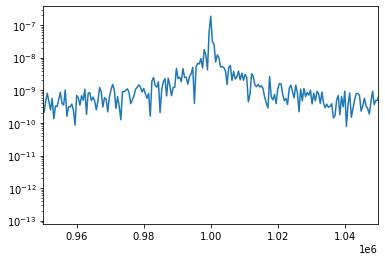

In [20]:
psd = np.zeros(Nt)
for i in range(50):
    phases = np.random.uniform(-np.pi,np.pi,Nt)
    noise_ff = f_ampl*np.exp(1j*phases)
    psd += np.abs(np.fft.ifft(noise_ff*h))**2
psd /= 50
plt.semilogy(f[:len(f)//2],(np.abs(np.fft.fft(x)))[:len(f)//2])
plt.xlim(9.5e5,10.5e5)

1.9715824573970317e-11


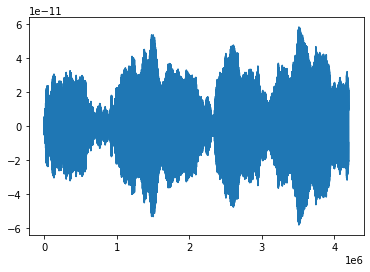

In [21]:
dt = 5e-9
steps = 2**22
from numba import njit
@njit
def simul(x,F):
    v = 0
    x[0] = 5e-12
    for i in range(1,steps):
        a = F[i]/m_eff - omega0/Q * v - omega0**2 * x[i-1]
        v += a*dt
        x[i] = x[i-1]+dt*v
    return x
x = np.zeros(steps)
F = np.random.normal(0,np.sqrt(Sth/dt),steps)
x = simul(x,F)
plt.plot(x)
print(np.std(x))

(900000.0, 1100000.0)

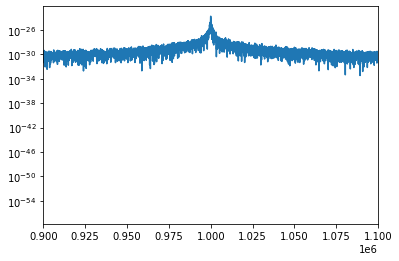

In [23]:
from scipy import signal
f,psd =signal.periodogram(x, 1/dt)
plt.semilogy(f,psd)
plt.xlim(9e5,11e5)

In [29]:
from scipy.optimize import curve_fit
@njit
def Sxx(f,f0,Qv,m):
    return k*T/(m*f0*2*np.pi*Qv) * 1/((2*np.pi*(f-f0))**2 + (np.pi*f0/Qv)**2)
mask = np.logical_and(f>9e5 ,f<11e5)
popt, pcov = curve_fit(Sxx, f[mask], psd[mask],p0=[1e6,Q,m_eff], maxfev=10000)

[[ 2.05601248e-01 -8.48106360e-01 -1.17038028e-17]
 [-8.48106360e-01  3.80396051e+03  6.71743576e-14]
 [-1.17038028e-17  6.71743576e-14  2.40599958e-30]]
[9.99970962e+05 7.10870001e+03 2.47711992e-13]


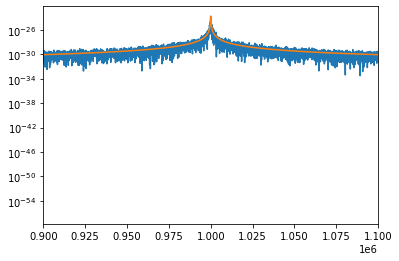

In [30]:
from scipy import signal
plt.semilogy(f,psd)
plt.semilogy(f,Sxx(f,*popt))
plt.xlim(9e5,11e5)
print(pcov)
print(popt)

(980000.0, 1020000.0)

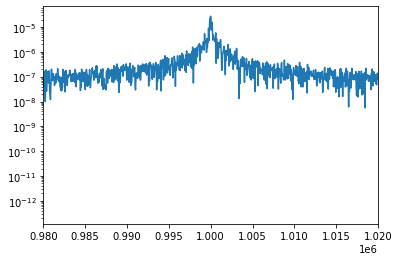

In [31]:
plt.semilogy(f,np.abs(np.fft.fft(x)[:len(f)]))
plt.xlim(9.8e5,10.2e5)

In [180]:
def lorentz(f,f0, Qval,m):
    return (4*k*T*2*np.pi*f0*m/Qval)/(np.abs((2*np.pi*f0)**2 - (2*np.pi*f)**2 + 1j*(2*np.pi*f)*(2*np.pi*f0)/Qval))
mask = np.logical_and(f>9.8e5 ,f<10.2e5)
ydata = np.abs(np.fft.fft(x)[:len(f)])
popt, pcov = curve_fit(lorentz, f[mask], ydata[mask],p0=[4000,1e6,1e3])
print(pcov)

[[ 5.20631064e+04 -4.31889037e+02 -4.99162302e+15]
 [-4.31889037e+02  2.51128525e+01  2.18263344e+14]
 [-4.99162302e+15  2.18263344e+14  1.93335192e+27]]


(980000.0, 1020000.0)

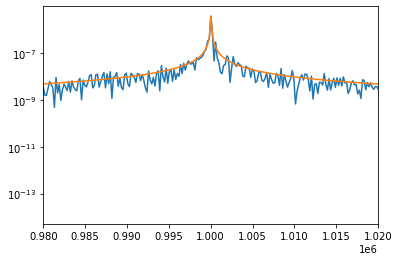

In [181]:
plt.semilogy(f,np.abs(np.fft.fft(x)[:len(f)]))
plt.semilogy(f,lorentz(f,popt[0],popt[1],popt[2]))
plt.xlim(9.8e5,10.2e5)

In [184]:
popt

array([7.65245450e+03, 1.00004867e+06, 5.28643832e+07])

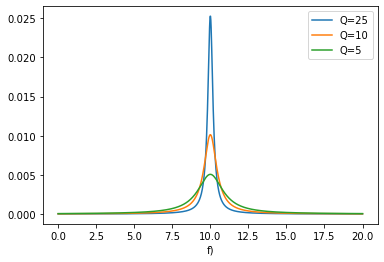

In [20]:
def Lor(f,f0,Qv):
    return 1/Qv * 1/((2*np.pi*(f-f0))**2 + (np.pi*f0/Qv)**2)

f = np.linspace(0, 20, 1000)
plt.plot(f,Lor(f,10,25),label='Q=25')
plt.plot(f,Lor(f,10,10),label='Q=10')
plt.plot(f,Lor(f,10,5),label='Q=5')
plt.xlabel("x")
plt.ylabel('$S_{xx$')
plt.legend()